In [7]:
%%javascript

# Bind cmd-shift-d to duplicate line of code
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('cmd-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

__Universal Robot Control__

In [10]:
import urx
import time, pickle
import numpy as np
import math3d as m3d

In [11]:
robot = urx.Robot("10.42.0.162", use_rt=True)

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 69
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1093
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


In [12]:
robot.set_digital_out(0, 1)
time.sleep(1)
robot.set_digital_out(0, 0)

In [13]:
robot.set_tcp((0, 0, 0.05, 0, 0, 0)) #ckeck Installation tab

In [146]:
robot.translate((0, 0.05, 0.), acc=0.05, vel=0.05) #acceleration, velocity

<Transform:
<Orientation: 
array([[ -7.07128291e-01,   7.07085269e-01,   4.43385209e-05],
       [  7.07085261e-01,   7.07128269e-01,   2.11877127e-04],
       [  1.18462174e-04,   1.81175426e-04,  -9.99999977e-01]])>
<Vector: (0.04509, -0.35623, 0.27137)>
>

In [42]:
robot.translate_tool((0, 0, 0.03), acc=0.05, vel=0.05)

<Transform:
<Orientation: 
array([[ -7.06934145e-01,  -7.07279349e-01,  -1.93678685e-04],
       [ -7.07279350e-01,   7.06934167e-01,  -7.33670102e-05],
       [  1.88809051e-04,   8.51192899e-05,  -9.99999979e-01]])>
<Vector: (0.18844, 0.11129, 0.30946)>
>

In [43]:
robot.get_pose()

<Transform:
<Orientation: 
array([[ -7.06968147e-01,  -7.07245366e-01,   1.77102959e-04],
       [ -7.07245387e-01,   7.06968137e-01,  -1.21884234e-04],
       [ -3.90040894e-05,  -2.11423521e-04,  -9.99999977e-01]])>
<Vector: (0.18846, 0.11128, 0.30951)>
>

In [44]:
robot.get_pos()

<Vector: (0.18845, 0.11128, 0.30949)>

In [45]:
robot.getl()

[0.18844639047179304,
 0.11128505741645678,
 0.30950237070627684,
 -1.2025131553746746,
 2.902220217720705,
 -0.0002166425235109268]

In [14]:
def save_current_pos(fname):
    p = robot.getl()
    np.savetxt(fname, np.array(p))
       

def move_to_pos(fname, *args, **kwargs):
    p = np.loadtxt(fname)
    robot.movel(p, *args, **kwargs)
    
def print_pos(fname):
    p = np.loadtxt(fname)
    print(p)
    

In [25]:
save_current_pos('take_photo')

In [42]:
def move_x_y(x, y):
    p = np.array(robot.getl())
    p[0] = x
    p[1] = y
    robot.movel(p, vel=0.05, acc=0.05)

In [ ]:
move_to_pos("in", vel=0.05, acc=0.05)

In [ ]:
robot.getl()

In [ ]:
robot.x += 0.01 #1 hour 10 minutes up to this point

In [ ]:
p = robot.get_pos()

In [ ]:
p.array

In [ ]:
m3d.Vector(p.array)

In [113]:
import threading
from IPython.display import display
import ipywidgets as widgets
import time

fw = widgets.HTML(
    value='',
    placeholder='No data',
    description='Force:',
)

def observe_force(fw):
    while True:
        fw.value = "<br>".join(["{0:5} {1:7.3f}".format(*c) for c in 
                                zip("x y z rx ry rz".split(), robot.get_tcp_force())])

thread = threading.Thread(target=observe_force, args=(fw,))
display(fw)
thread.start()



In [114]:
robot.get_tcp_force().__str__()

'[-5.50243915 -6.9897237  -5.2953105   0.41093459 -0.68804832  0.75343419]'

__Here starts CV__

In [3]:
%matplotlib notebook

import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import signal, time 
import numpy as np
from numpy import linalg
#to check: cv2.getBuildInformation()
print (*filter(lambda s: "FFMPEG" in s, cv2.getBuildInformation().split("\n")))
print (*filter(lambda s: "V4L" in s, cv2.getBuildInformation().split("\n")))

#To install opencv with ffmpeg in conda
#https://github.com/conda-forge/opencv-feedstock/
#pip uninstall opencv
#pip uninstall opencv-python
#conda unistall opencv
#conda install conda=4.0.11
#conda config --add channels conda-forge
#conda install opencv


    FFMPEG:                      NO
    V4L/V4L2:                    YES/YES


In [4]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [156]:
%%bash
ls -d -1 /dev/* | grep video

/dev/video0
/dev/video1


In [169]:
vc = cv2.VideoCapture("/dev/video1") #0 for the first webcam, 1 for the second..

In [170]:
def imshow(frame, from_color_space='bgr'):
    plt.figure()
    if from_color_space == 'bgr':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    elif from_color_space == 'hsv':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)    # makes the blues image look real colored
    else:
        rgb_frame=frame
    return plt.imshow(rgb_frame)

def online_view():
    if vc.isOpened(): # try to get the first frame
        is_capturing, frame = vc.read()
        webcam_preview = imshow(frame)   
    else:
        is_capturing = False

    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False
    while is_capturing:
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        webcam_preview.set_data(frame)
        plt.draw()

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05)
        except Exception:
            pass
        if is_interrupted:
            vc.release()
            break
    
def get_frame():
    timeout = time.time() + 0.1
    while time.time() < timeout:
        if vc.isOpened(): # try to get the first frame
            is_capturing, frame = vc.read()
        else:
            raise (Exception("Unable to capture"))
    return frame



<IPython.core.display.Javascript object>


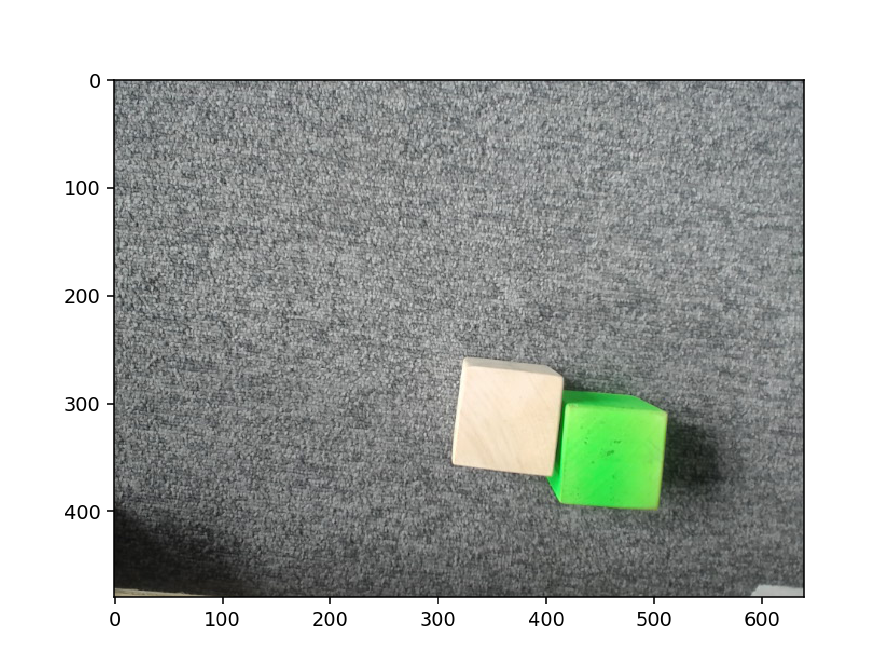

In [171]:
imshow(get_frame())
#online_view()

In [172]:
# online_view()

__The blob detection__

In [181]:
move_to_pos('take_photo', acc=0.05, vel=0.05)

In [182]:
def find_colored_cubes_centers_pixels(colorMin, colorMax, blur=40, verbose=0):
    # Read image
    # im = cv2.imread("detection/cubes_4.png")
    im = get_frame()
    cv2.imwrite('test.png', im)

    if verbose > 0: imshow(im)

    # Blur image to remove noise
    im = cv2.GaussianBlur(im, (5,5), blur)

    if verbose > 2: imshow(im)

    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    #greenMin = (30, 90, 120) #./range-detector.py -i test.png -f HSV
    #greenMax = (150, 255, 255)

    # Sets pixels to white if in purple range, else will be set to black
    mask = cv2.inRange(hsv, colorMin, colorMax)

    # Bitwise-AND of mask and purple only image - only used for display
    masked = cv2.bitwise_and(im, im, mask= mask)

    if verbose > 2: imshow(masked)

    # dilate makes the in range areas larger
    mask = cv2.erode(mask, None, iterations=5)

    # mask = cv2.dilate(mask, None, iterations=8)


    # Bitwise-AND of mask and purple only image - only used for display
    masked = cv2.bitwise_and(im, im, mask= mask)

    if verbose > 1: imshow(masked)
    pts = []

    # find contours in the mask and initialize the current
    # (x, y) center of the ball
    cnts = cv2.findContours(mask.copy(), cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    center = None

    if verbose > 1: print (len(cnts))

    # only proceed if at least one contour was found
    for c in cnts:
        # find the largest contour in the mask, then use
        # it to compute the minimum enclosing circle and
        # centroid
    #     c = max(cnts, key=cv2.contourArea)
        (circle_center, radius) = cv2.minEnclosingCircle(c)

        # only proceed if the radius meets a minimum size
        if radius > 25 and radius < 200:
            if verbose > 1: print (radius)

            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            if center[1] > 400:
                continue
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
            circle_center_int = tuple(map(int, circle_center))
            cv2.circle(im, circle_center_int, int(radius),
                (0, 255, 255), 2)
            cv2.circle(im, center, 5, (0, 0, 255), -1)
            cv2.circle(im, circle_center_int, 3,
                (0, 255, 255), -1)

            # update the points queue
            pts.append(circle_center)

    if verbose > 0: imshow(im)
    return pts

<IPython.core.display.Javascript object>


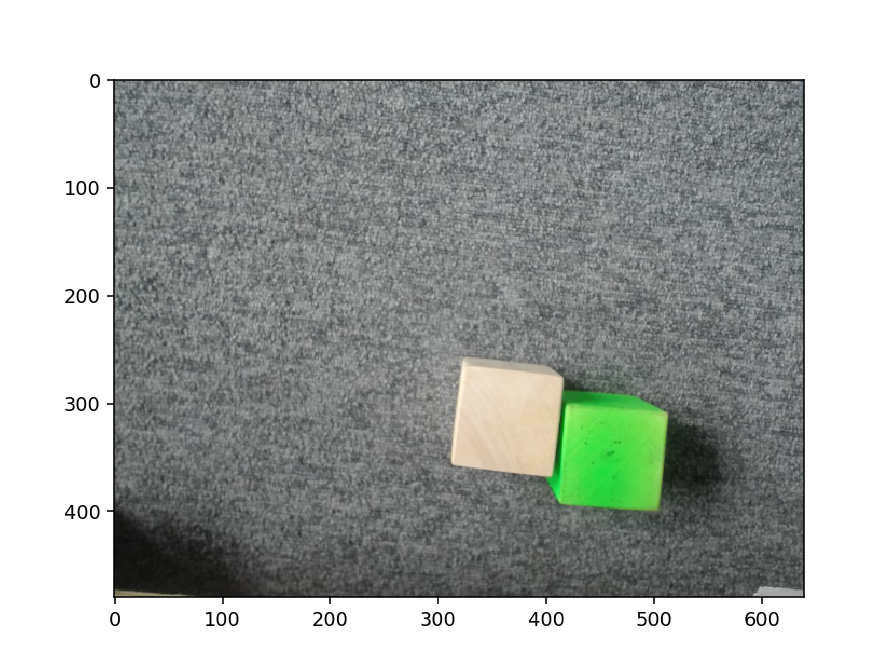

<IPython.core.display.Javascript object>


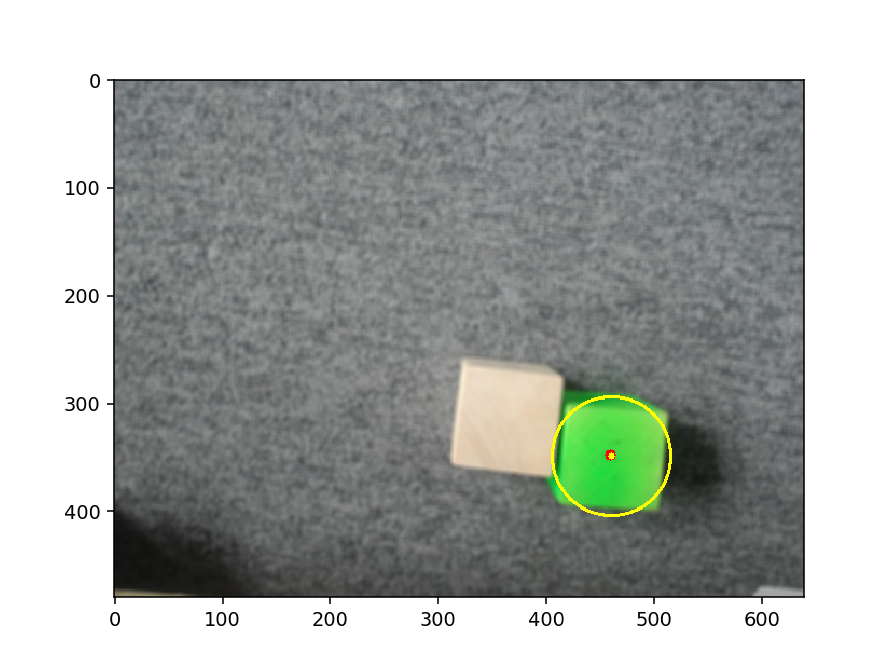

In [183]:
green_min = (30, 75, 186) #./range-detector.py -i test.png -f HSV
green_max = (88, 255, 255)
im = find_colored_cubes_centers_pixels(green_min, green_max, verbose=1)

In [186]:
def find_green_cubes_centers_pixels(*args, **kwargs):
    green_min = (30, 75, 186) #./range-detector.py -i test.png -f HSV
    green_max = (88, 255, 255)
    return find_colored_cubes_centers_pixels(green_min, green_max, *args, **kwargs)

def find_plain_cubes_centers_pixels(*args, **kwargs):
    plain_min = (11, 45, 233) #./range-detector.py -i test.png -f HSV
    plain_max = (176, 93, 255)
    return find_colored_cubes_centers_pixels(plain_min, plain_max, *args, **kwargs)


<IPython.core.display.Javascript object>


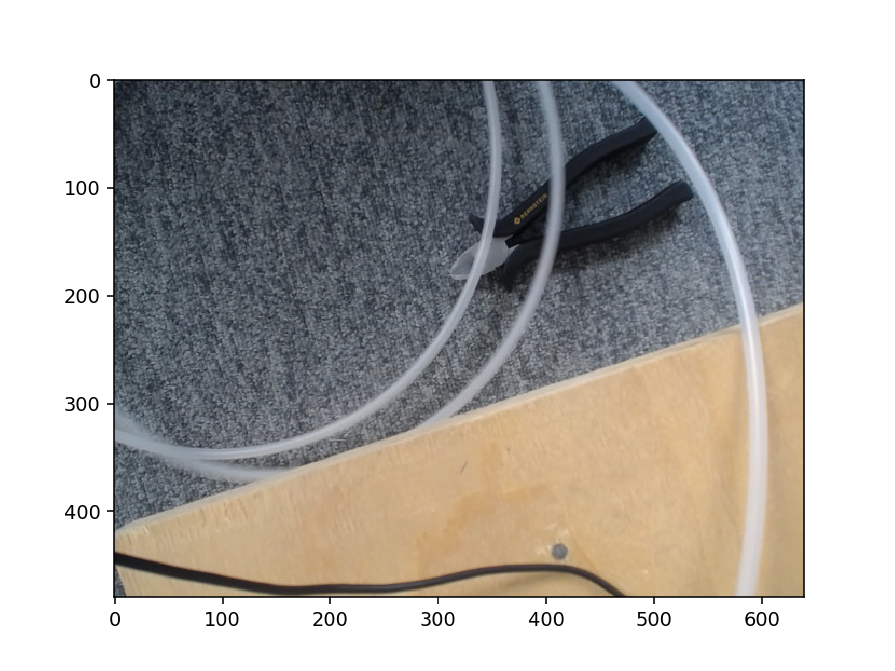

<IPython.core.display.Javascript object>


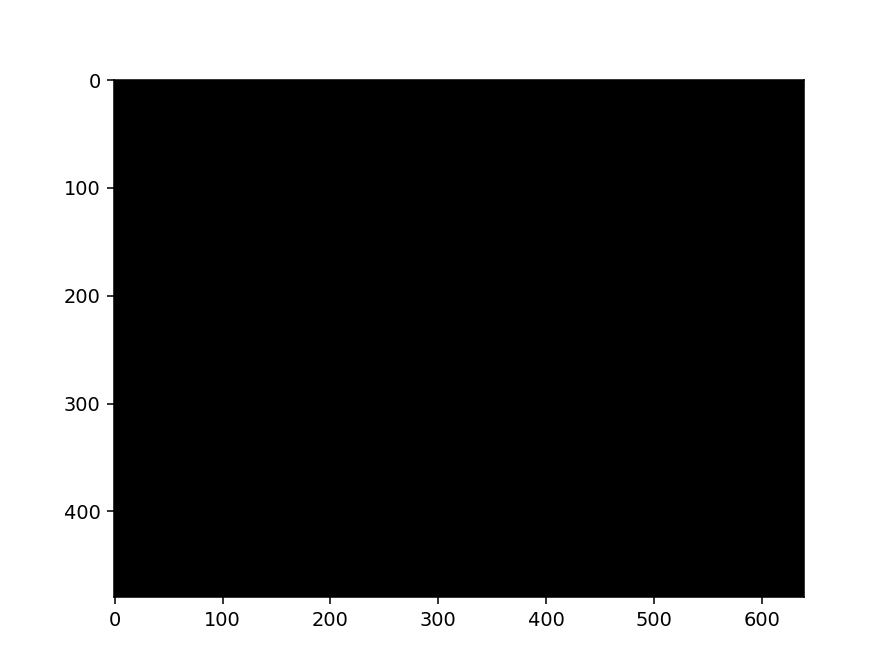

0


<IPython.core.display.Javascript object>


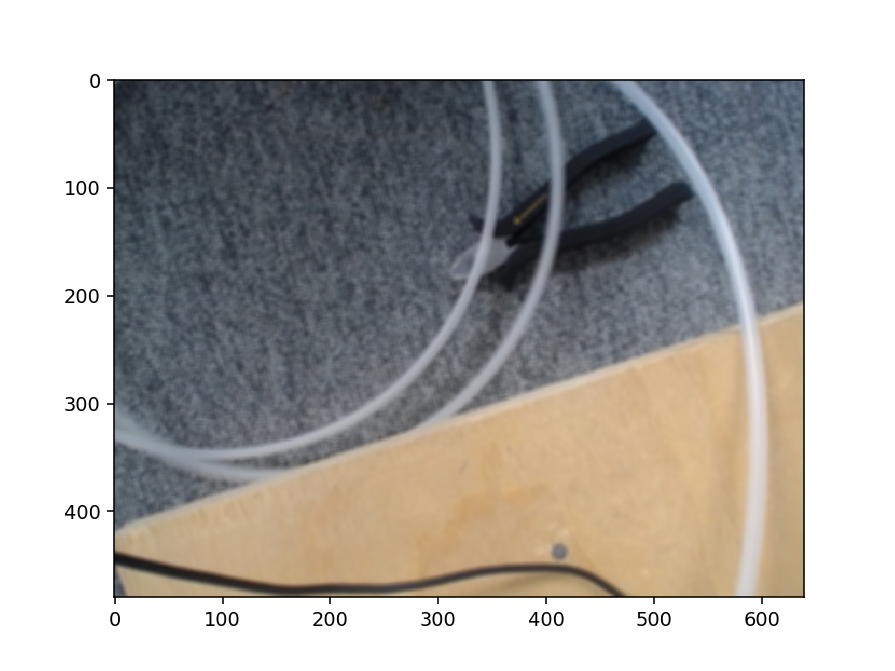

[]

In [179]:
find_plain_cubes_centers_pixels(verbose=2)

In [108]:
# save_current_pos('green')

In [187]:
# move_to_pos('in', acc=0.05, vel=0.05)

In [188]:
# save_current_pos('pink')

In [204]:
class RobotCamera(object):
    def calibrate(self, verbose=0):
        self.calibrate_rotation_and_scale(verbose=verbose)
        self.calibrate_shift(verbose=verbose)
    
    def calibrate_rotation_and_scale(self, verbose=0):
        scale, angle = self.calibrate_once(verbose=verbose)
        
        self.scale, self.angle = scale, angle
        if verbose > 0: print ("scale: {}, angle: {}".format(scale, angle))
        c, s = np.cos(self.angle), np.sin(self.angle)
        self.rotation_matrix = np.matrix([[c, -s], [s, c]])
        return self.scale, self.angle
        
    def calibrate_once(self, delta_pos=(0.05, 0, 0), verbose=0):
        """Calibrates the robot, if it has only one green cube in sight"""
        if delta_pos[2] != 0:
            raise NotImplemented
        delta_pos = np.asarray(delta_pos)
        move_to_pos("take_photo", vel=0.05, acc=0.05)
        pos1 = np.array(find_green_cubes_centers_pixels(verbose=verbose)[0])

        robot.translate(delta_pos, acc=0.05, vel=0.05) #acceleration, velocity
        pos2 = np.array(find_green_cubes_centers_pixels(verbose=verbose)[0])
        if verbose > 0: print ("Pos 1: {}\nPos 2: {}\n".format(pos1, pos2))

        delta_pos_pix = -(pos2 - pos1)

        distance_pixels = linalg.norm(delta_pos_pix)
        distance_space = linalg.norm(delta_pos[:1])

        scale = distance_space/distance_pixels
#         angle = np.arccos(np.sum(delta_pos_pix*delta_pos[:1])
#                           /linalg.norm(delta_pos_pix) 
#                           /linalg.norm(delta_pos[:1])
#                          )
        complex_pix = delta_pos_pix[0] + 1j*delta_pos_pix[1]
        complex_space = delta_pos[0] + 1j*delta_pos[1]
        angles = np.angle((complex_pix, complex_space))
        return scale, angles[1]-angles[0]
    
    def calibrate_shift(self, verbose=0):
        move_to_pos("take_photo", vel=0.05, acc=0.05)
        pos_pix = np.array(find_green_cubes_centers_pixels(verbose=verbose)[0])
        robot.set_freedrive(1)
        input("Now move the robot head to the green cube. Press Enter to confirm")
        robot.set_freedrive(0)
        pos_space = robot.getl()[:1]
        if verbose > 1: print("pos_space: {}".format(pos_space))
        move_to_pos("take_photo", vel=0.05, acc=0.05)
        
        proposed_coordinates = self.scale*self.rotation_matrix.dot(pos_pix)
        self.shift = pos_space - proposed_coordinates
        if verbose > 0: print ("shift: {}".format(self.shift))
        return self.shift

        

    def get_real_coords(self, point):
        return self.scale*self.rotation_matrix.dot(point) + self.shift

def check_targ():
    move_to_pos("take_photo", vel=0.05, acc=0.05)
    imag = green_take()

    x, y = get_real_coords(imag[0])

    p = np.array(robot.getl())
    p[0] = x
    p[1] = y
    p[2] = 0.015
    robot.movel(p, vel=0.05, acc=0.05)
    p[2] = -0.04
    robot.movel(p, vel=0.05, acc=0.05)
    p[2] = 0.05
    robot.movel(p, vel=0.05, acc=0.05)
    robot.set_digital_out(0, 1)
    time.sleep(1)


    return x, y

def sort():
    while True:
        move_to_pos("start", vel=0.15, acc=0.05)
        green = green_take()
        pink = pink_take()
        if len(green) == 0 and len(pink) == 0:
            time.sleep(10)
            continue

        take_green = len(green)

        box = green[0] if take_green else pink[0]
        x, y = get_real_coords(box)

        p = np.array(robot.getl())
        p[0] = x
        p[1] = y
        p[2] = 0.015
        robot.movel(p, vel=0.5, acc=0.2)
        p[2] = -0.04
        robot.movel(p, vel=0.05, acc=0.2)
        robot.set_digital_out(0, 1)
        p[2] = 0.15
        robot.movel(p, vel=0.2, acc=0.1)
        if take_green:
            move_to_pos("green", vel=0.5, acc=0.2)
        else:
            move_to_pos("pink", vel=0.5, acc=0.2)
        robot.set_digital_out(0, 0)





<IPython.core.display.Javascript object>


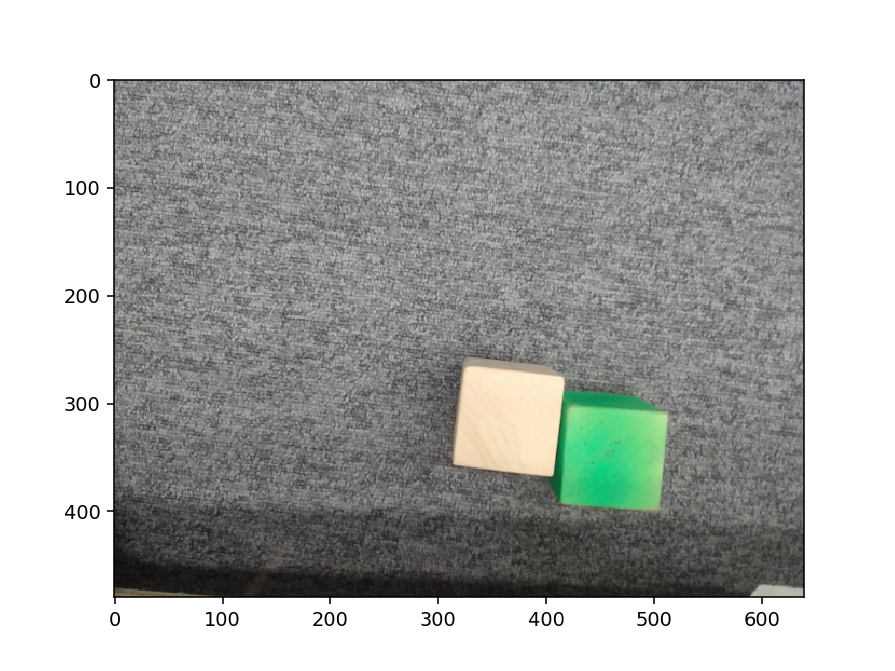

<IPython.core.display.Javascript object>


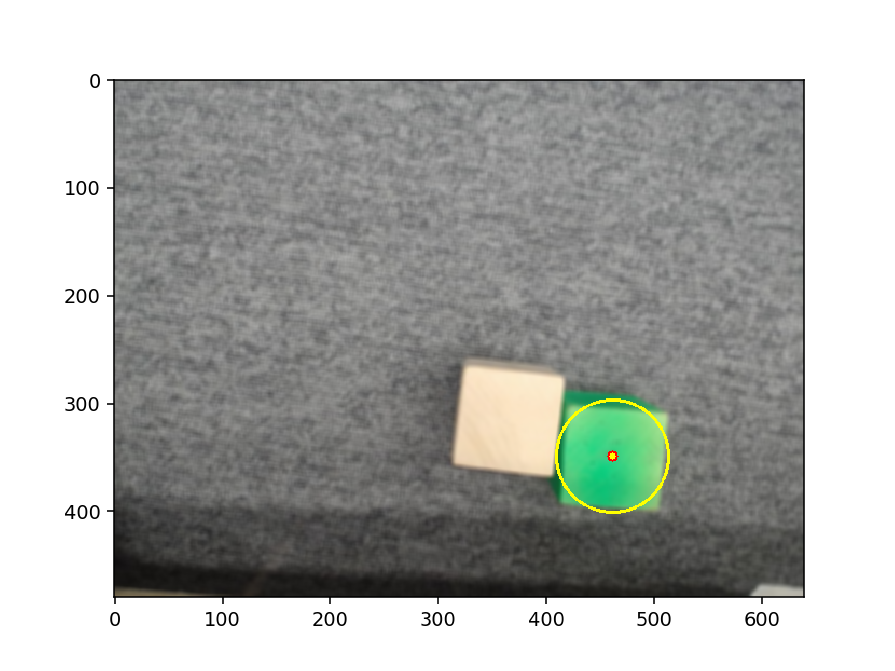

<IPython.core.display.Javascript object>


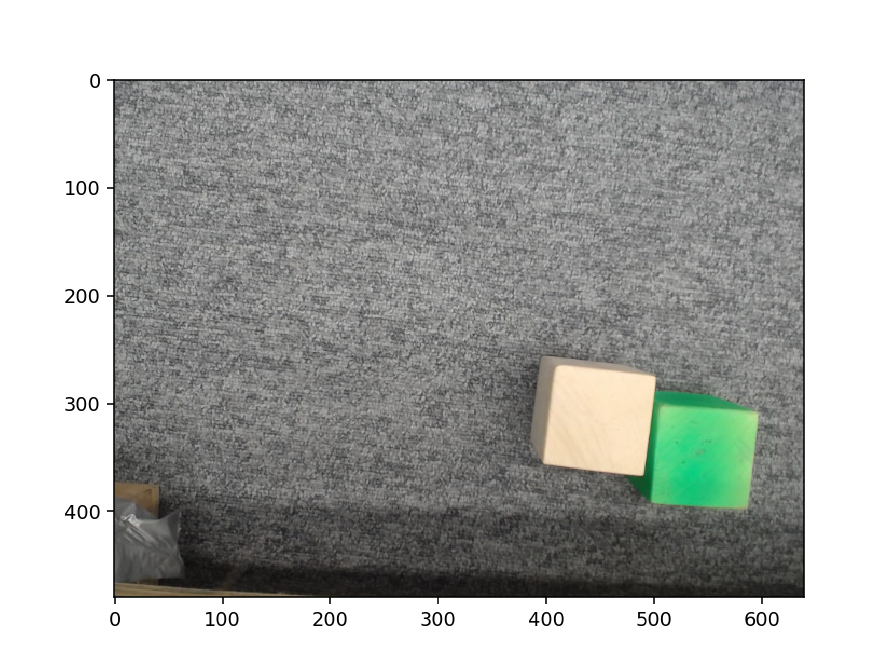

<IPython.core.display.Javascript object>


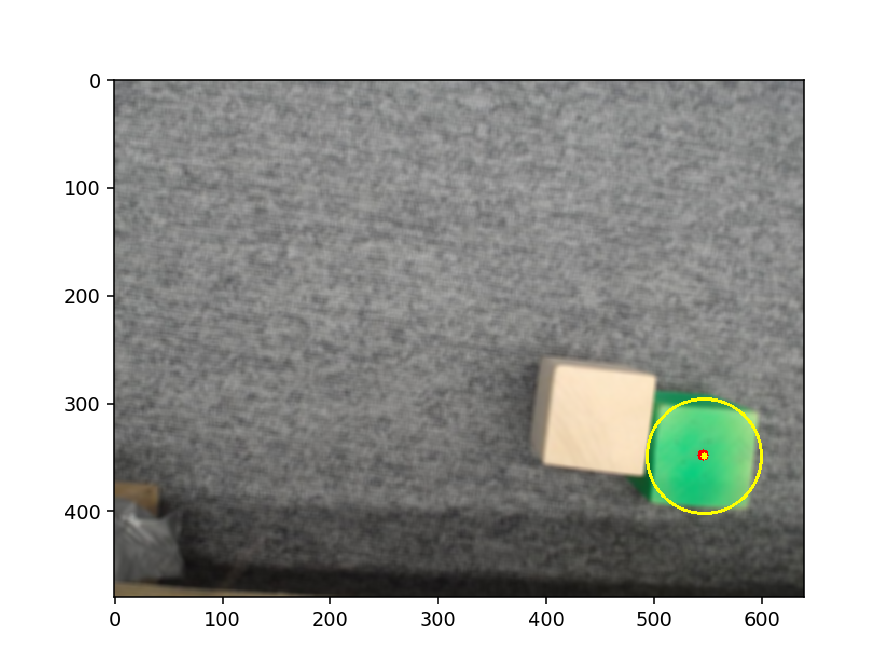

Pos 1: [ 462.68988037  349.89657593]
Pos 2: [ 547.45281982  349.94241333]

scale: 0.0005898803535099246, angle: 3.1410518819014666


<IPython.core.display.Javascript object>


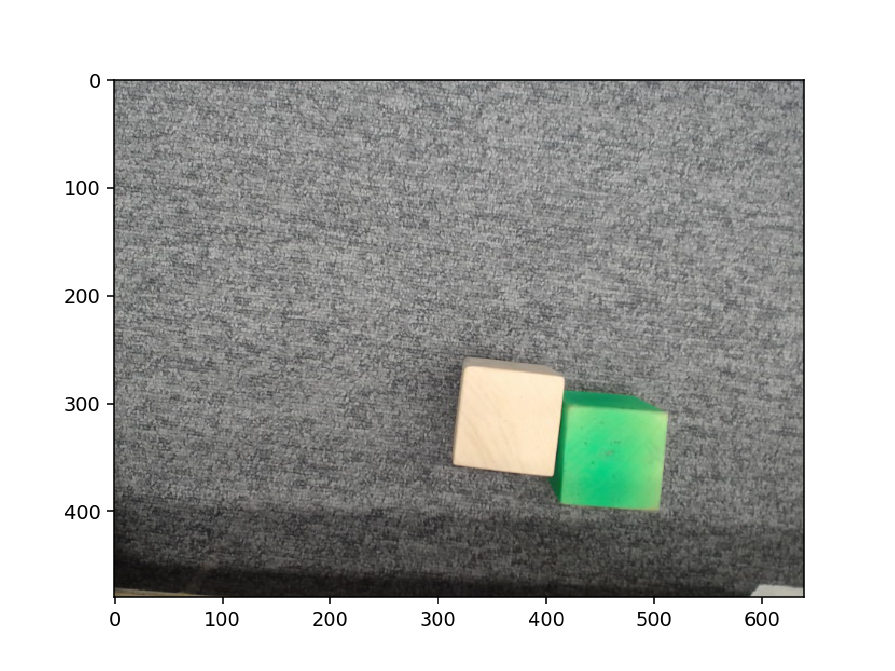

<IPython.core.display.Javascript object>


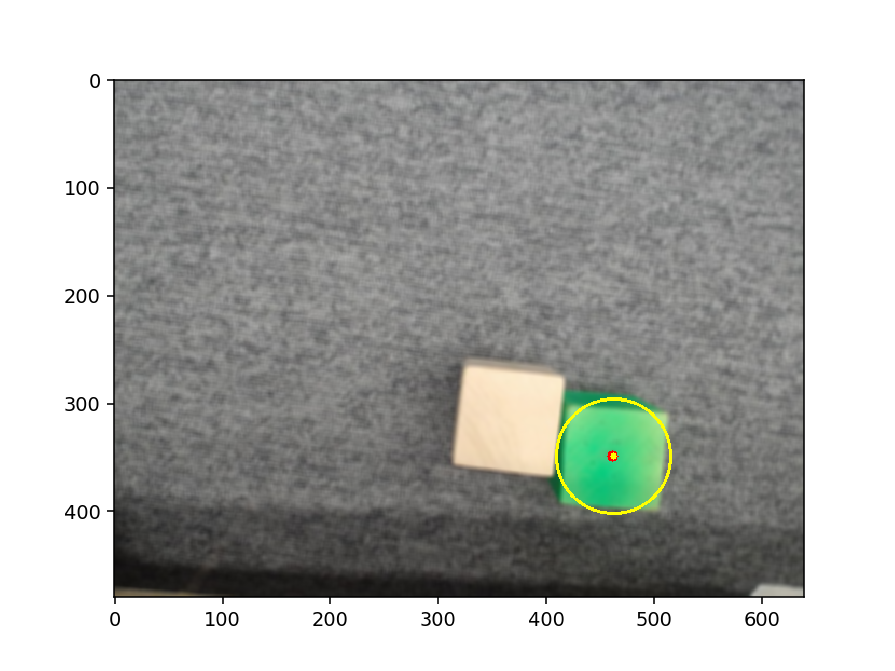

Now move the robot head to the green cube. Press Enter to confirm
shift: [[ 0.23925104  0.17222744]]


In [205]:
rc = RobotCamera()
rc.calibrate(verbose=1)

In [208]:
robot.getl()

[-0.04047287907750067,
 -0.3081701120826219,
 0.004504209903617049,
 1.6288419566171692,
 2.683812666836828,
 -0.0636171070846791]

In [209]:
rc.get_real_coords((458, 347))

matrix([[-0.03102481, -0.03231491]])

In [110]:
sort()

2
52.500099182128906
51.41264724731445
1
40.463008880615234
1
53.85701370239258
1
50.152366638183594
1
53.85701370239258
1
50.152366638183594
0
1
50.152366638183594
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
1
0
1
0
1
0


KeyboardInterrupt: 